# Data Preparation

In [1]:
#import libraries

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from imblearn.over_sampling import SMOTE

# Loading Dataset

In [2]:
# https://archive-beta.ics.uci.edu/ml/datasets/cervical+cancer+risk+factors
"""
The dataset was collected at 'Hospital Universitario de Caracas' in Caracas, Venezuela.
The dataset comprises demographic information, habits, and historic medical records of 858 patients.
Several patients decided not to answer some of the questions because of privacy concerns (missing values).
"""

rf = pd.read_csv('risk_factors_cervical_cancer.csv',encoding='utf8')
rf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 36 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   Age                                 858 non-null    int64 
 1   Number of sexual partners           858 non-null    object
 2   First sexual intercourse            858 non-null    object
 3   Num of pregnancies                  858 non-null    object
 4   Smokes                              858 non-null    object
 5   Smokes (years)                      858 non-null    object
 6   Smokes (packs/year)                 858 non-null    object
 7   Hormonal Contraceptives             858 non-null    object
 8   Hormonal Contraceptives (years)     858 non-null    object
 9   IUD                                 858 non-null    object
 10  IUD (years)                         858 non-null    object
 11  STDs                                858 non-null    object

# Covert data to usable datatypes

In [3]:
# replace missing values with NaN
rf = rf.replace('?',np.nan)

# covert everything to float64, some classes will be converted to bool once missing values are taken care of
for label, col in rf.iteritems():
    rf[label] = pd.to_numeric(col, errors='coerce')

#TODO: Age is still int after this, why?

# Examine data

# Check missing values per column

In [4]:
percent_missing = rf.isnull().sum() * 100 / len(rf)
missing_value_df = pd.DataFrame({'column_name': rf.columns,
                                 'percent_missing': percent_missing})
missing_value_df

column_name  \
Age                                                                Age   
Number of sexual partners                    Number of sexual partners   
First sexual intercourse                      First sexual intercourse   
Num of pregnancies                                  Num of pregnancies   
Smokes                                                          Smokes   
Smokes (years)                                          Smokes (years)   
Smokes (packs/year)                                Smokes (packs/year)   
Hormonal Contraceptives                        Hormonal Contraceptives   
Hormonal Contraceptives (years)        Hormonal Contraceptives (years)   
IUD                                                                IUD   
IUD (years)                                                IUD (years)   
STDs                                                              STDs   
STDs (number)                                            STDs (number)   
STDs:condylomatosis                                STDs:condylomatosis   
STDs:cervical condylomatosis              STDs:cervical condylomatosis   
STDs:vaginal condylomatosis                STDs:vaginal condylomatosis   
STDs:vulvo-perineal condylomatosis  STDs:vulvo-perineal condylomatosis   
STDs:syphilis                                            STDs:syphilis   
STDs:pelvic inflammatory disease      STDs:pelvic inflammatory disease   
STDs:genital herpes                                STDs:genital herpes   
STDs:molluscum contagiosum                  STDs:molluscum contagiosum   
STDs:AIDS                                                    STDs:AIDS   
STDs:HIV                                                      STDs:HIV   
STDs:Hepatitis B                                      STDs:Hepatitis B   
STDs:HPV                                                      STDs:HPV   
STDs: Number of diagnosis                    STDs: Number of diagnosis   
STDs: Time since first diagnosis      STDs: Time since first diagnosis   
STDs: Time since last diagnosis        STDs: Time since last diagnosis   
Dx:Cancer                                                    Dx:Cancer   
Dx:CIN                                                          Dx:CIN   
Dx:HPV                                                          Dx:HPV   
Dx                                                                  Dx   
Hinselmann                                                  Hinselmann   
Schiller                                                      Schiller   
Citology                                                      Citology   
Biopsy                                                          Biopsy   

                                    percent_missing  
Age                                        0.000000  
Number of sexual partners                  3.030303  
First sexual intercourse                   0.815851  
Num of pregnancies                         6.526807  
Smokes                                     1.515152  
Smokes (years)                             1.515152  
Smokes (packs/year)                        1.515152  
Hormonal Contraceptives                   12.587413  
Hormonal Contraceptives (years)           12.587413  
IUD                                       13.636364  
IUD (years)                               13.636364  
STDs                                      12.237762  
STDs (number)                             12.237762  
STDs:condylomatosis                       12.237762  
STDs:cervical condylomatosis              12.237762  
STDs:vaginal condylomatosis               12.237762  
STDs:vulvo-perineal condylomatosis        12.237762  
STDs:syphilis                             12.237762  
STDs:pelvic inflammatory disease          12.237762  
STDs:genital herpes                       12.237762  
STDs:molluscum contagiosum                12.237762  
STDs:AIDS                                 12.237762  
STDs:HIV                                  12.237762  
STDs:Hepatitis B        

In [5]:
# remove columns with more than 20% missing
selection_columns = missing_value_df.loc[missing_value_df['percent_missing'] >= 20].iloc[:, 0]

for col in selection_columns:
    rf = rf.drop([col], axis=1)

# Investigate STDs (number) vs STDs: Number of diagnosis

In [6]:
# check if STDs (number) and STDs: Number of diagnosis are the same
STD_comparison = np.where((rf['STDs (number)']==rf['STDs: Number of diagnosis']), True, False)

# remove one of the columns if they're not the same and replace values in the other column with newly calc values
if not STD_comparison.all():
    rf = rf.drop(['STDs: Number of diagnosis'], axis=1)
    # create a new row with the sum of all STDs
    rf['STDs (number)'] = (rf['STDs:condylomatosis'] + rf['STDs:cervical condylomatosis'] +
        rf['STDs:vaginal condylomatosis'] + rf['STDs:vulvo-perineal condylomatosis'] +
        rf['STDs:syphilis'] + rf['STDs:pelvic inflammatory disease'] +
        rf['STDs:genital herpes'] + rf['STDs:molluscum contagiosum'] +
        rf['STDs:AIDS'] + rf['STDs:HIV'] +
        rf['STDs:Hepatitis B'] + rf['STDs:HPV'])

# Check missing values per row

In [7]:
missing_count = []
for idx in range(len(rf)):
    missing = rf.loc[[idx]].isna().sum().sum()
    missing_count.append(missing)

removed = 0
for idx, val in enumerate(missing_count):
    # Remove all rows where more than 20% of the data are missing
    # TODO: decide if we want to do 15% instead as in paper?
    if val >= len(rf.columns)*0.2:
        rf = rf.drop(idx)
        removed+=1
print("{} number of rows were removed".format(removed))

106 number of rows were removed


# Data imputation
Following the methods described in:
Razali, Nazim & Mostafa, Salama & Mustapha, Aida & Abd Wahab, Mohd Helmy & Ibrahim, Nurul. (2020). Risk Factors of Cervical Cancer using Classification in Data Mining. Journal of Physics: Conference Series. 1529. 022102. 10.1088/1742-6596/1529/2/022102. 

"Missing values for attribute that have integer data type were filled using the sample mean while boolean
were filled using the sample mode."

In [8]:
# store columns with specific data type
bool_columns = ['Smokes','Hormonal Contraceptives', 'IUD', 'STDs',
                'STDs:condylomatosis', 'STDs:cervical condylomatosis',
                'STDs:vaginal condylomatosis', 'STDs:vulvo-perineal condylomatosis',
                'STDs:syphilis', 'STDs:pelvic inflammatory disease', 
                'STDs:genital herpes', 'STDs:molluscum contagiosum',
                'STDs:AIDS', 'STDs:HIV', 'STDs:Hepatitis B', 'STDs:HPV',
                'Dx:Cancer', 'Dx:CIN', 'Dx:HPV', 'Dx', 'Hinselmann', 'Schiller',
                'Citology', 'Biopsy']

# replace NaN with mode for columns with dtype bool
for label, col in rf.iteritems():
    if label in bool_columns:
        columns_mode = col.mode()
        rf[label] = col.fillna(columns_mode[0])

        #convert column to bool while we're at it
        rf[label] = rf[label].astype('bool')
    
float_columns = rf.select_dtypes(include=['float64']).columns

# replace NaN with mean for columns with dtype float
for col in float_columns:
    columns_mean = rf[col].mean()
    rf[col] = rf[col].fillna(columns_mean)

# Investigate class imbalances

In [9]:
# What is difference between Dx:Cancer and Biopsy?
rf['Dx:Cancer'].value_counts()

False    734
True      18
Name: Dx:Cancer, dtype: int64

In [10]:
rf['Biopsy'].value_counts()

False    699
True      53
Name: Biopsy, dtype: int64

In [11]:
rf['STDs'].value_counts()

False    673
True      79
Name: STDs, dtype: int64

# Correlations between variables

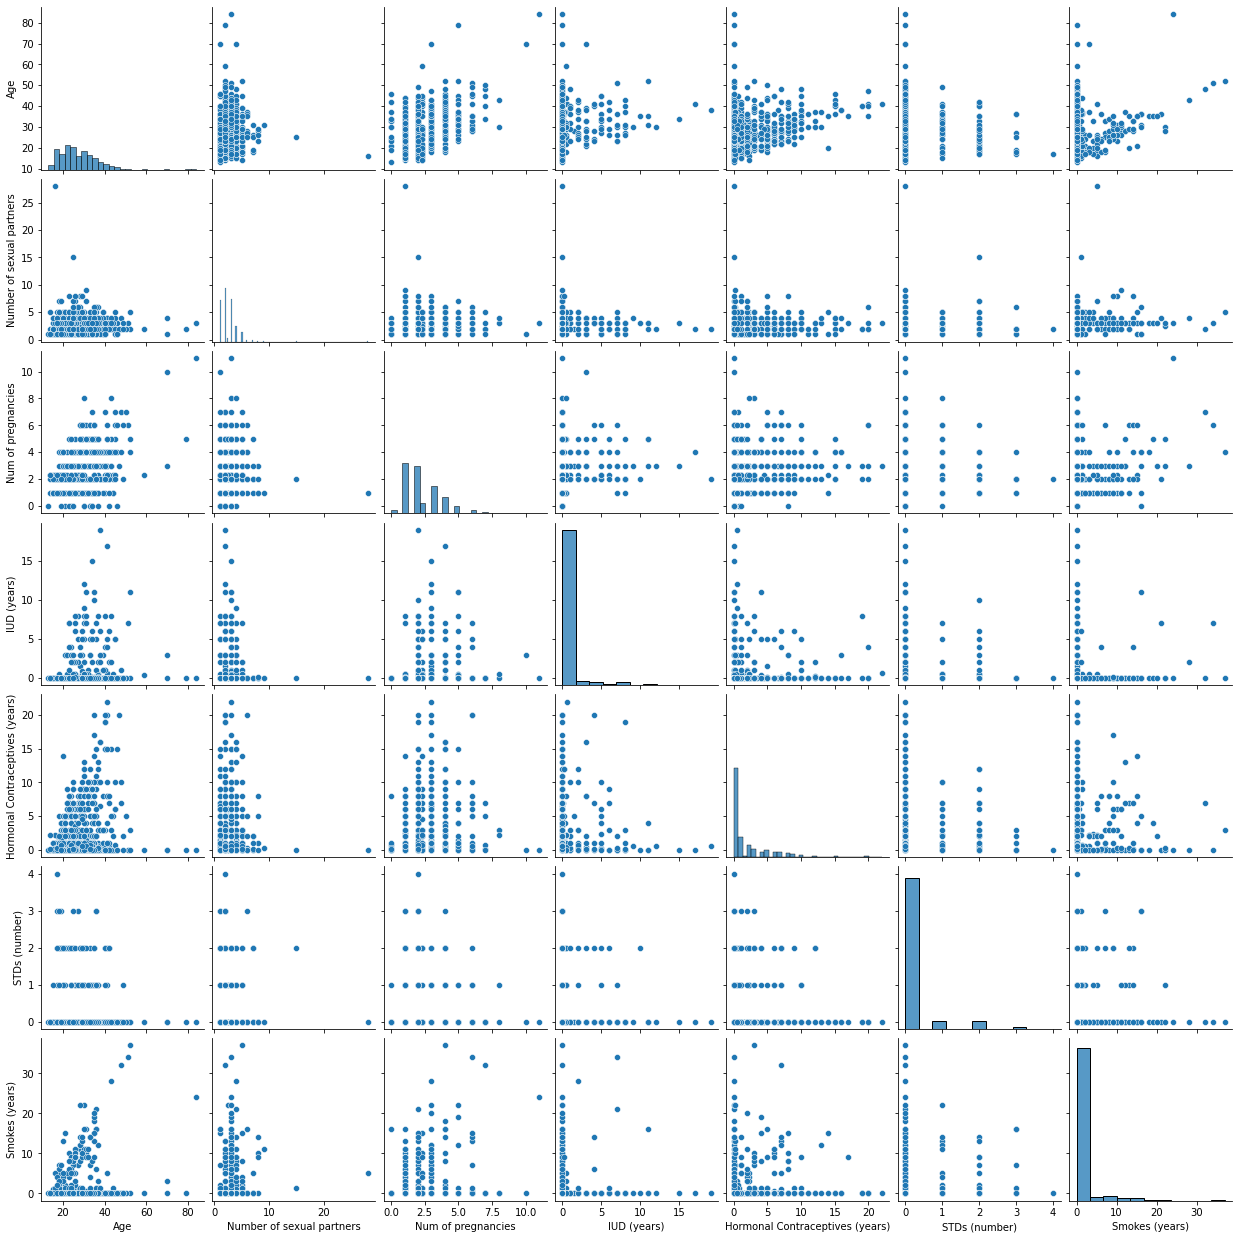

In [12]:
# Plot non-bool parameters
sns.pairplot(rf[['Age','Number of sexual partners','Num of pregnancies','IUD (years)',
                 'Hormonal Contraceptives (years)', 'STDs (number)', 'Smokes (years)']])

# Implement Oversampling

In [13]:
# locate all columns where Biopsy is 1
minority_class = rf.loc[rf['Biopsy'] == 1]

print("Minority class count before oversampling: \n{}\n".format(rf['Biopsy'].value_counts()))

# oversample with factor 12.2
minority_class = minority_class.sample(frac=12.2, replace=True, random_state=1)

# concat dataframes
frames = [rf, minority_class]
rf_oversampled = pd.concat(frames)

print("Minority class count after oversampling: \n{}".format(rf_oversampled['Biopsy'].value_counts()))

Minority class count before oversampling: 
False    699
True      53
Name: Biopsy, dtype: int64

Minority class count after oversampling: 
True     700
False    699
Name: Biopsy, dtype: int64


# SMOTE oversampling


In [15]:
# oversampling using synthetic minority oversampling technique (SMOTE)
# see: Chawla N V, Bowyer K W, Hall L O and Kegelmeyer W P 2002 Journal of Artificial Intelligence Research 16 321-357

# following tutorial here: https://www.kite.com/blog/python/smote-python-imbalanced-learn-for-oversampling/
rf.to_csv('rf_original.csv', index=False, encoding='utf-8')


# for reproducibility purposes
seed = 100
# SMOTE number of neighbors
k = 1

rf = pd.read_csv('rf_original.csv', encoding='utf-8', engine='python')

# make a new df made of all the columns, except the target class
X = rf.loc[:, rf.columns != 'Biopsy']
y = rf.Biopsy
sm = SMOTE(sampling_strategy='auto', k_neighbors=k, random_state=seed)
X_res, y_res = sm.fit_resample(X, y)

rf_smote = pd.concat([pd.DataFrame(X_res), pd.DataFrame(y_res)], axis=1)

# rename the columns
column_names  = rf.columns.values.tolist()
rf_smote.columns = column_names

print("Minority class count after SMOTE oversampling: \n{}".format(rf_smote['Biopsy'].value_counts()))

Minority class count after SMOTE oversampling: 
False    699
True     699
Name: Biopsy, dtype: int64


# Pivot table

In [ ]:
group = 'Dx:Cancer'
column_ = 'Dx:HPV'
agg_function = np.mean 

pivot_sum=pd.pivot_table(rf,index=[group],values=[column_],aggfunc=agg_function)
pivot_sum=pivot_sum.reset_index()
pivot_sum

# Box plots

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
sns.boxplot(data=rf[rf.columns[0:4]])